In [7]:
from pyrdf2vec.graphs import KG
import rdflib
import random 
import numpy as np

In [238]:
#kg = KG(location="../data/aifbfixed_complete.n3", file_type="n3")
#kg = KG(location="../data/bgs.nt", file_type="nt")
kg = KG(location="../data/mutag.xml", file_type="xml")

# 1. Get the entitites and corresponding classes

In [239]:
g = rdflib.Graph()
#g.parse("../data/aifbfixed_complete.n3", format="n3")
#g.parse("../data/bgs.nt", format="nt")
g.parse("../data/mutag.xml", format="xml")

q = g.query("""SELECT ?entity ?type
            WHERE {
              ?entity rdf:type ?type.
            }""")
entities = []
classes = []
for row in q:
    entities.append(row[0])
    classes.append(row[1])

In [240]:
set(classes)

{rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Alcohol'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Alkyl_halide'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Amine'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Amino'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Ar_halide'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Arsenic-101'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Barium-115'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Bond-1'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Bond-2'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Bond-3'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Bond-7'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Bromine-94'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Calcium-84'),
 rdflib.term.URIRef('http://dl-learner.org/carcinogenesis#Carbon-10'),
 rdflib.term.URIRef(

# 2. Filtering

In [241]:
filtered_index = []
index = 0
for e in entities:
    if e in kg._entities:
        filtered_index.append(index)
    index += 1
    
entities_filt = [entities[i] for i in filtered_index]
classes_filt = [classes[i] for i in filtered_index]

entities = entities_filt

Each class is a string like "http://swrc.ontoware.org/ontology#TechnicalStaff". We do some preprocessing to obtain a more natural presentation (by deleting the leading characters).

In [246]:
classes = []
for class_type in classes_filt:
    #class_type = class_type.lstrip("http://swrc.ontoware.org/ontology#")
    #class_type = class_type.lstrip("3.org/2002/07/owl#")
    class_type = class_type.lstrip("'www.w3.org/2002/07/owl#")
    class_type = class_type.lstrip("http://dl-learner.org/carcinogenesis#")
    classes.append(class_type)

Finally, each entity is one of the following set of classes:

In [247]:
print(set(classes))

{'Sulfur-70', 'Lead-121', 'Sulfur-74', 'Ring_size_4', 'Compound', 'Hydrogen-1', 'Oxygen-51', 'Alkyl_halide', 'Methanol', 'Cyanate', 'Sulfide', 'Nitrogen-35', 'Carbon-16', 'Non_ar_hetero_6_ring', 'Carbon-10', 'Carbon-192', 'Di48', 'Ketone', 'Carbon-193', 'Carbon-26', 'Carbon-29', 'Sulfur-76', 'www.w3.org/2002/07/owl#Ontology', 'Carbon-21', 'Di281', 'Oxygen-45', 'Ether', 'Halide10', 'Mercury-120', 'www.w3.org/2002/07/owl#DatatypeProperty', 'Bromine-94', 'Hydrogen-3', 'Oxygen-49', 'Di227', 'Nitrogen-34', 'Oxygen-53', 'Di260', 'Carbon-14', 'Alcohol', 'Sulfur-72', 'Nitro', 'Bond-1', 'Titanium-134', 'Ester', 'Methyl', 'Chlorine-93', 'Oxygen-50', 'Di232', 'Ar_halide', 'Nitrogen-33', 'Bond-3', 'Di8', 'www.w3.org/2002/07/owl#Class', 'Di23', 'Non_ar_hetero_5_ring', 'Nitrogen-36', 'Oxygen-41', 'Nitrogen-32', 'Sulfur-77', 'Di67a', 'Sulfur-79', 'Phosphorus-62', 'Manganese-85', 'Ethoxy', 'Carbon-191', 'Nitrogen-37', 'Sulfur-78', 'Di66', 'Methoxy', 'Carbon-27', 'Phosphorus-60', 'Fluorine-92', 'Nitrog

# 3. Import the embeddings

In [251]:
#data = "aifb" # aifb, mutag, or bgs
data = "mutag"
nlp_model = "cbow" # skip-gram or cbow
num_embeddings = 10
embeddings = []

dim_red = "pca2d" # empty string "", "pca2d", "pca3d", "tsne2d", or "tsne3d"

# read embeddings:
if dim_red=="":
    for iter in range(num_embeddings):
        embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/embedding" + str(iter) + ".npy"))
else:
    for iter in range(num_embeddings):
        embeddings.append(np.load("embeddings/" + data + "/" + nlp_model + "/" + dim_red + "/embedding" + str(iter) + ".npy"))

# 4. Logistic Regression classifier

In [252]:
X = embeddings[0]
y = np.array(classes)

In [253]:
X[:, 1]

array([-0.05061945,  0.05629288,  0.05968494, ..., -0.0561415 ,
        0.03079605, -0.00231991], dtype=float32)

In [254]:
set(y)

{'Alcohol',
 'Alkyl_halide',
 'Amine',
 'Amino',
 'Ar_halide',
 'Arsenic-101',
 'Barium-115',
 'Bond-1',
 'Bond-2',
 'Bond-3',
 'Bond-7',
 'Bromine-94',
 'Calcium-84',
 'Carbon-10',
 'Carbon-14',
 'Carbon-15',
 'Carbon-16',
 'Carbon-17',
 'Carbon-19',
 'Carbon-191',
 'Carbon-192',
 'Carbon-193',
 'Carbon-21',
 'Carbon-22',
 'Carbon-232',
 'Carbon-26',
 'Carbon-27',
 'Carbon-29',
 'Chlorine-93',
 'Compound',
 'Copper-96',
 'Cyanate',
 'Di10',
 'Di227',
 'Di23',
 'Di232',
 'Di260',
 'Di281',
 'Di48',
 'Di51',
 'Di64',
 'Di66',
 'Di67a',
 'Di8',
 'Ester',
 'Ether',
 'Ethoxy',
 'Five_ring',
 'Fluorine-92',
 'Halide10',
 'Hydrogen-1',
 'Hydrogen-2',
 'Hydrogen-3',
 'Hydrogen-8',
 'Imine',
 'Iodine-95',
 'Ketone',
 'Krypton-83',
 'Lead-121',
 'Manganese-85',
 'Mercury-120',
 'Methanol',
 'Methoxy',
 'Methyl',
 'Nitro',
 'Nitrogen-31',
 'Nitrogen-32',
 'Nitrogen-33',
 'Nitrogen-34',
 'Nitrogen-35',
 'Nitrogen-36',
 'Nitrogen-37',
 'Nitrogen-38',
 'Nitrogen-499',
 'Non_ar_5c_ring',
 'Non_ar_6c

In [255]:
for class_type in set(y):
    print(class_type)
    print(len(X[np.where(y==class_type)]))

Sulfur-70
9
Lead-121
1
Sulfur-74
24
Ring_size_4
5
Compound
340
Hydrogen-1
355
Oxygen-51
74
Alkyl_halide
173
Methanol
17
Cyanate
2
Sulfide
62
Nitrogen-35
23
Carbon-16
115
Non_ar_hetero_6_ring
87
Carbon-10
1162
Carbon-192
7
Di48
10
Ketone
143
Carbon-193
6
Carbon-26
16
Carbon-29
31
Sulfur-76
2
www.w3.org/2002/07/owl#Ontology
1
Carbon-21
36
Di281
2
Oxygen-45
159
Ether
336
Halide10
54
Mercury-120
1
www.w3.org/2002/07/owl#DatatypeProperty
15
Bromine-94
45
Hydrogen-3
3632
Oxygen-49
100
Di227
11
Nitrogen-34
15
Oxygen-53
2
Di260
1
Carbon-14
170
Alcohol
110
Sulfur-72
3
Nitro
87
Bond-1
6781
Titanium-134
2
Ester
147
Methyl
378
Chlorine-93
281
Oxygen-50
131
Di232
6
Ar_halide
320
Nitrogen-33
2
Bond-3
6
Di8
5
www.w3.org/2002/07/owl#Class
142
Di23
13
Non_ar_hetero_5_ring
78
Nitrogen-36
52
Oxygen-41
4
Nitrogen-32
242
Sulfur-77
11
Di67a
5
Sulfur-79
1
Phosphorus-62
9
Manganese-85
1
Ethoxy
10
Carbon-191
22
Nitrogen-37
3
Sulfur-78
22
Di66
4
Methoxy
77
Carbon-27
55
Phosphorus-60
6
Fluorine-92
7
Nitrogen-38


Note: Most of these types are eiter a Person, or a Publication with like 1/3 vs 2/3 proportion.

In [216]:
from sklearn.preprocessing import StandardScaler

X_cp = X.copy()
scaler = StandardScaler()
X_cp_scaled = scaler.fit_transform(X_cp)

[[ 0.17190258 -0.0567601 ]
 [ 0.00510532 -0.18624233]
 [-0.00146338  0.21117626]
 ...
 [-0.14667284  0.37698597]
 [-0.14063022 -0.04628789]
 [-0.19873455 -0.13790472]]


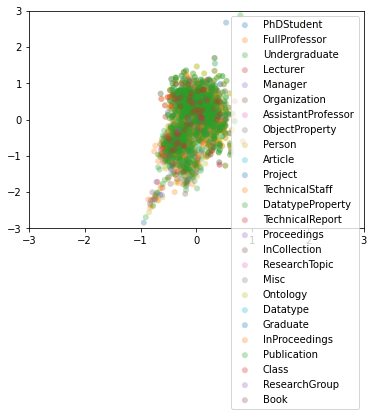

In [219]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
#color = 
for class_type in set(y):
    index = np.where(y==class_type)
    ax.scatter(X_cp_scaled[index, 0], X_cp_scaled[index,1], label=class_type,
               alpha=0.3, edgecolors='none')
ax.legend()
ax.set_ylim([-3, 3])
ax.set_xlim([-3,3])
plt.show()

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

993